In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, Lambda, Conv1D, Input, BatchNormalization
from keras.models import Model
#import plotly.offline as py
#import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
#py.init_notebook_mode(connected=True)
#from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
#import fix_yahoo_finance as yf
%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
Stock="AAPL"
param = {
    'q': Stock, # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    # Stock exchange symbol on which stock is traded (ex: "NASD")
     'p':'5Y'# Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
#df = get_price_data(param)
  
#df = yf.download(Stock,'2001-10-06')
#df.to_csv(Stock+'.csv')
df=pd.read_csv(Stock+'.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4297,2018-07-27,194.990005,195.190002,190.100006,190.979996,190.979996,24024000
4298,2018-07-30,191.899994,192.199997,189.070007,189.910004,189.910004,21029500
4299,2018-07-31,190.300003,192.139999,189.339996,190.289993,190.289993,39373000
4300,2018-08-01,199.130005,201.759995,197.309998,201.500000,201.500000,67841600
4301,2018-08-02,200.580002,208.380005,200.350006,207.800003,207.800003,50325158


In [7]:
data=df
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [8]:
def Bolinger_Bands(stock_price, window_size, num_of_std):

    rolling_mean = stock_price.rolling(window=window_size).mean()
    rolling_std  = stock_price.rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std*num_of_std)
    lower_band = rolling_mean - (rolling_std*num_of_std)

    return rolling_mean, upper_band, lower_band
Avg, Upper, Lower = Bolinger_Bands(data['Close'], 10, 2)
def OBV(data):
    last_obv = 0
    obv = [last_obv]
    for i in range(1,len(data)):
        if data['Close'][i] >= data['Close'][i-1]:
            obv.append(last_obv + data['Volume'][i])
        else:
            obv.append(last_obv - data['Volume'][i])
        last_obv = obv[-1]
    return pd.DataFrame(obv, columns=['OBV'])
def Bias(data, period=6):
    MA = data['Close'].rolling(window=period).mean()
    bias=[]
    for i in range(len(data)):
        bias.append(((data['Close'][i]-MA[i])/MA[i])*100)
    return pd.DataFrame(bias, columns=['Bias'])
def PSY(data, period=12):
    psy = [np.nan]*(period-1)
    for i in range(len(data)-period+1):
        diff = np.ediff1d(data['Close'][i:i+period])
        psy.append((len(diff[diff>=0])/len(diff))*100)
    return pd.DataFrame(psy, columns=['PSY'])
def SY(data, i, p):
    return ((data['Close'][i-p]-data['Close'][i-p-1])/data['Close'][i-p-1])*100

def ASY(data, period):
    if period == 1:
        asy = [np.nan]*2
        for i in range(2,len(data)):
            asy.append(((data['Close'][i-1]-data['Close'][i-2])/data['Close'][i-2])*100)
    else:
        asy = [np.nan]*period
        for i in range(period,len(data)):
            A=0
            for j in range(period):
                A = A + SY(data, i,j)
            A = A/(j+1)
            asy.append(A)
            
    return pd.DataFrame(asy, columns=['ASY'+str(period)])


In [6]:
from stockstats import StockDataFrame
indicators = ['close_50_sma','close_150_sma','close_20_ema','close_40_ema','boll','boll_ub','boll_lb',\
             'macd','kdjk','kdjd','kdjj','atr','adx','vr','rsi_14']
for i in indicators:
    df = StockDataFrame.retype(data)
    df = df.get(i)

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
print(data.shape)
data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
print(data.shape)

(4302, 7)
(4302, 7)


In [8]:
diff=np.ediff1d(data.iloc[:,3])
diff.shape
Data = np.append(data.values[:-1,:], diff.reshape(-1,1), axis=1)

In [9]:
Data.shape

(4299, 57)

In [9]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['Open'] + ['High'] + ['Low'] + ['Close'] + ['Volume']]
# values.insert(5,'OBV',OBV(data))
# #values.insert(2,'Volume',data['Volume'])#.rolling(window=50).mean())
# values.insert(6,'MA5',data['Close'].rolling(window=5).mean())
# values.insert(7,'Bias',Bias(data,6))
# values.insert(8,'PSY12',PSY(data,12))
# values.insert(9,'ASY1',ASY(data,1))
# values.insert(10,'ASY2',ASY(data,2))
# values.insert(11,'ASY3',ASY(data,3))
# values.insert(12,'ASY4',ASY(data,4))
# values.insert(13,'ASY5',ASY(data,5))
# diff = np.ediff1d(data['Close'])
# diff=np.append(np.array([0]),diff)
# values.insert(14,'diff',diff)
#values.insert(4,'MA150',data['Close'].rolling(window=150).mean())
#values.insert(5, 'EMA20', data['Close'].ewm(span=20, adjust=False).mean())
#values.insert(13, 'Lower', Lower)
#values.insert(14, 'Avg', Avg)
#values.insert(15, 'Upper', Upper)
#values.insert(5,'open', data['Open'])
#values=values.iloc[:,1:]
values.dropna(inplace=True)
#values=values.values
values = values.astype('float32')

C:\Users\alahghol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
values.head()

,Open,High,Low,Close,Volume,OBV,MA5,Bias,PSY12,ASY1,ASY2,ASY3,ASY4,ASY5
11,1.723571,1.786429,1.702857,1.775000,113685600.0,244389600.0,1.651286,8.341811,54.545456,8.074534,5.043014,5.569515,2.459068,2.575527
12,1.777143,1.792857,1.707857,1.711429,69666800.0,174722800.0,1.669286,3.016857,45.454544,2.011494,-0.784985,2.168188,3.281770,1.250962
13,1.712857,1.801429,1.643571,1.792857,161957600.0,336680384.0,1.725857,6.093684,54.545456,-3.581465,0.588215,1.062642,2.815615,3.576995
14,1.555714,1.627143,1.458571,1.485000,284253184.0,52427200.0,1.700857,-11.906782,45.454544,4.757895,-6.206707,-5.331626,-3.495846,-1.181770
15,1.516429,1.530000,1.410714,1.425714,215284992.0,-162857792.0,1.638000,-13.854139,45.454544,-17.171309,-10.581816,-5.468579,-4.996800,-3.595141


In [176]:
#values = data.iloc[1:,:]
values = values.values
#values = Data
#values = values[~np.isnan(values).any(axis=1)]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
#scaler = StandardScaler()
#scaler.fit(values)
#scaled = scaler.transform(values)
#scaled = normalize(values, norm='l2',axis=0)
#scaled = scale(values)

In [10]:
scaled = (values.values[:-1,:]/values.values[1:,:])
scaled = pd.DataFrame(scaled)
#scaled.replace([np.inf, -np.inf], np.nan)
#scaled = scaled.dropna()
all_inf_or_nan = scaled.isin([np.inf, -np.inf, np.nan]).all(axis='columns')
scaled = scaled[~all_inf_or_nan]
scaled = scaled.values

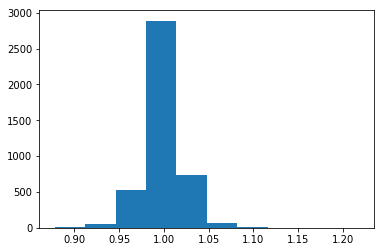

In [11]:
import matplotlib.pyplot as plt
plt.hist(scaled[:,3])
plt.show()

In [2]:
stocks=['OI','NI','UPS','HSIC','CCE','IBM','MAS','EFX','AAPL','WDC']
Train_X=np.empty((0,15,5))
Train_y=np.empty((0,2))
Test_X=np.empty((0,15,5))
Test_y=np.empty((0,2))
for Stock in stocks:
    df=pd.read_csv(Stock+'.csv')
    data=df
    data['Close'].replace(0, np.nan, inplace=True)
    data['Close'].fillna(method='ffill', inplace=True)
    values = data[['Open'] + ['High'] + ['Low'] + ['Close'] + ['Volume']]
    values.dropna(inplace=True)
    values = values.astype('float32')
    scaled = (values.values[:-1,:]/values.values[1:,:])-1
    scaled = pd.DataFrame(scaled)
    all_inf_or_nan = scaled.isin([np.inf, -np.inf, np.nan]).all(axis='columns')
    scaled = scaled[~all_inf_or_nan]
    scaled = scaled.values
    scaled2=scaled.copy()
    s=np.append(scaled, np.zeros((1,scaled.shape[1])),axis=0)
    data_gen = TimeseriesGenerator(scaled[:], scaled[:,3],
                                   length=15, sampling_rate=1,
                                   stride=1, batch_size=len(s-1))
    X, y = data_gen[0]
    y = np.ediff1d(scaled[:,3])
    data_gen = TimeseriesGenerator(y, y,
                                  length=15, sampling_rate=1,
                                  stride=1, batch_size=len(y))
    _, y_seq = data_gen[0]
    y=y_seq
    X = X[:-1]
    y1 = np.empty([len(y)], dtype=np.float32)
    for i in range(len(y)):
        if y[i] >= 0.0:
            y1[i] = 1.0
        else:
            y1[i] = 0.0
    y1=to_categorical(y1)
    train_X = X[:-20]
    train_y = y1[:-20]
    train_X, train_y = shuffle(train_X, train_y, random_state = 1)
    test_X = X[-20:]
    test_y = y1[-20:]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    Train_X = np.concatenate((Train_X,train_X),axis=0)
    Train_y = np.concatenate((Train_y,train_y),axis=0)
    Test_X = np.concatenate((Test_X,test_X),axis=0)
    Test_y = np.concatenate((Test_y,test_y),axis=0)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(4260, 15, 5) (4260, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)
(4198, 15, 5) (4198, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)
(4260, 15, 5) (4260, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)
(4264, 15, 5) (4264, 2) (20, 15, 5) (20, 2)
(4255, 15, 5) (4255, 2) (20, 15, 5) (20, 2)


In [3]:
print(Train_X.shape, Train_y.shape, Test_X.shape, Test_y.shape)

(42512, 15, 5) (42512, 2) (200, 15, 5) (200, 2)


In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
#scaled=values
scaled2=scaled.copy()
#scaled=scaled[:-15]
s=np.append(scaled, np.zeros((1,scaled.shape[1])),axis=0)
data_gen = TimeseriesGenerator(scaled[:], scaled[:,3],
                               length=15, sampling_rate=1,
                               stride=1, batch_size=len(s-1))
X, y = data_gen[0]
print(X.shape, y.shape)
y = np.ediff1d(scaled[:,3])
print(y.shape)
data_gen = TimeseriesGenerator(y, y,
                              length=15, sampling_rate=1,
                              stride=1, batch_size=len(y))
_, y_seq = data_gen[0]
print(y_seq.shape)
y=y_seq
X = X[:-1]
print(X.shape, y.shape)
y1 = np.empty([len(y)], dtype=np.float32)
for i in range(len(y)):
    if y[i] >= 0.0:
        y1[i] = 1.0
    else:
        y1[i] = 0.0

#scaler = MinMaxScaler(feature_range=(0, 1))
print(y1.shape)
#y1=y1[:,-1]
y1=to_categorical(y1)
print(y1.shape)
# scaler = StandardScaler()
#scaler.fit(y.reshape(-1, 1))
#y1 = scaler.transform(y.reshape(-1, 1))
# #y1 = scale(y)
# print(X.shape, y1.shape)
#y1=y1*20
#y1=y
#X, y1 = shuffle(X, y1, random_state = 0)
train_X = X[:-20]
train_y = y1[:-20]
train_X, train_y = shuffle(train_X, train_y, random_state = 1)
valid_X = X[3500:3800]
valid_y = y1[3500:3800]
test_X = X[-20:]
test_y = y1[-20:]
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(4286, 15, 5) (4286,)
(4300,)
(4285,)
(4285, 15, 5) (4285,)
(4285,)
(4285, 2)
(4265, 15, 5) (4265, 2) (300, 15, 5) (300, 2) (20, 15, 5) (20, 2)


In [4]:
from keras.callbacks import ReduceLROnPlateau
from keras import metrics
from keras.initializers import he_normal, lecun_normal
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x):
    return (K.sigmoid(x*10)) 

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def tcn(h,filters=500, kernel_size=3, padding='causal', activation='relu', dilation_rate=1):
    main = BatchNormalization()(h)
    #main = h
    init = lecun_normal(seed=1)
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate, kernel_initializer=init)(main)
        main = Activation('relu')(main)
        main = BatchNormalization()(main)       
        main = Dropout(0.15)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same', kernel_initializer=init)(h)
    #side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

Inp = Input(shape=(15,5))
inp = Inp
D = [1,2,4,1,1]
for i in range(3):
    inp=tcn(inp,dilation_rate=D[i])
    #inp = BatchNormalization()(inp)
    #inp = Activation('relu')(inp)
inp=Flatten()(inp)
init = lecun_normal(seed=1)
inp=Dense(100)(inp)
inp = Activation('selu')(inp)
inp = BatchNormalization()(inp)
inp = Dropout(0.25)(inp)
inp=Dense(10)(inp)
inp = Activation('selu')(inp)
inp = BatchNormalization()(inp)
#inp = Dropout(0.25)(inp)
out=Dense(2,activation='softmax')(inp)
#inp = Lambda(lambda x: x * 2)(inp)
#inp = Lambda(lambda x: x/100)(inp)
model = Model(Inp,out)
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=ad, metrics=['accuracy'])
history = model.fit(Train_X, Train_y, epochs=50, batch_size=128, validation_split=0.1, verbose=1, shuffle=True)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 38260 samples, validate on 4252 samples
Epoch 1/50
38260/38260 [==============================] - 31s 811us/step - loss: 0.7310 - acc: 0.4988 - val_loss: 0.7112 - val_acc: 0.4984
Epoch 2/50
38260/38260 [==============================] - 25s 645us/step - loss: 0.6969 - acc: 0.5265 - val_loss: 0.7015 - val_acc: 0.4993
Epoch 3/50
38260/38260 [==============================] - 25s 650us/step - loss: 0.6919 - acc: 0.5358 - val_loss: 0.7001 - val_acc: 0.5108
Epoch 4/50
38260/38260 [==============================] - 25s 649us/step - loss: 0.6857 - acc: 0.5513 - val_loss: 0.7063 - val_acc: 0.4946
Epoch 5/50
38260/38260 [==============================] - 25s 647us/step - loss: 0.6819 - acc: 0.5597 - val_loss: 0.7067 - val_acc: 0.4991
Epoch 6/50
38260/38260 [==============================] - 25s 649us/step - loss: 0.6771 - acc: 0.5687 - val_loss: 0.7070 - val_acc: 0.5160
Epoch 7/50
38260/38260 [==========

KeyboardInterrupt: 

In [28]:
model.optimizer.lr = 0.00005
history = model.fit(Train_X, Train_y, epochs=50, batch_size=512, validation_split=0.1, verbose=1, shuffle=True)


Train on 38260 samples, validate on 4252 samples
Epoch 1/50
38260/38260 [==============================] - 9s 234us/step - loss: 0.6647 - acc: 0.5870 - val_loss: 0.7114 - val_acc: 0.5153
Epoch 2/50
38260/38260 [==============================] - 9s 235us/step - loss: 0.6650 - acc: 0.5850 - val_loss: 0.7150 - val_acc: 0.5141
Epoch 3/50
38260/38260 [==============================] - 9s 235us/step - loss: 0.6647 - acc: 0.5856 - val_loss: 0.7128 - val_acc: 0.5085
Epoch 4/50
38260/38260 [==============================] - 9s 233us/step - loss: 0.6634 - acc: 0.5885 - val_loss: 0.7191 - val_acc: 0.5047
Epoch 5/50
38260/38260 [==============================] - 9s 233us/step - loss: 0.6624 - acc: 0.5887 - val_loss: 0.7149 - val_acc: 0.5127
Epoch 6/50
38260/38260 [==============================] - 9s 235us/step - loss: 0.6627 - acc: 0.5894 - val_loss: 0.7221 - val_acc: 0.5075
Epoch 7/50
38260/38260 [==============================] - 9s 237us/step - loss: 0.6570 - acc: 0.5985 - val_loss: 0.7146 - v

KeyboardInterrupt: 

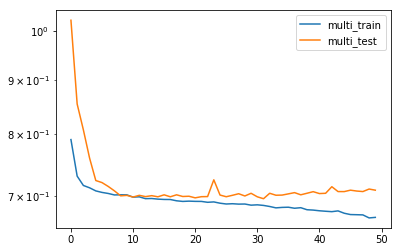

In [26]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

regession accuracy:

In [7]:
ind=[0,20,40,60,80,100,120,140,160,180]
for i in range(len(ind)):
    print(stocks[i],': ',model.evaluate(Test_X[ind[i]:ind[i]+20,:,:],Test_y[ind[i]:ind[i]+20,:]))

20/20 [==============================] - 0s 6ms/step
OI :  [0.8642728924751282, 0.44999998807907104]
20/20 [==============================] - 0s 562us/step
NI :  [0.9119715690612793, 0.4000000059604645]
20/20 [==============================] - 0s 432us/step
UPS :  [0.6756316423416138, 0.6499999761581421]
20/20 [==============================] - 0s 559us/step
HSIC :  [0.7868500351905823, 0.44999998807907104]
20/20 [==============================] - 0s 773us/step
CCE :  [0.7292312383651733, 0.4000000059604645]
20/20 [==============================] - 0s 470us/step
IBM :  [0.7381263971328735, 0.4000000059604645]
20/20 [==============================] - 0s 466us/step
MAS :  [0.7416006922721863, 0.4000000059604645]
20/20 [==============================] - 0s 457us/step
EFX :  [0.651324987411499, 0.699999988079071]
20/20 [==============================] - 0s 489us/step
AAPL :  [0.7989617586135864, 0.3499999940395355]
20/20 [==============================] - 0s 404us/step
WDC :  [0.9417148828

In [103]:
model.predict(Test_X)

array([[9.61005330e-01, 3.89947034e-02],
       [4.93819445e-01, 5.06180584e-01],
       [8.38182390e-01, 1.61817580e-01],
       [7.20646322e-01, 2.79353678e-01],
       [5.46712458e-01, 4.53287572e-01],
       [9.74178374e-01, 2.58216504e-02],
       [2.06980528e-03, 9.97930169e-01],
       [3.26695114e-01, 6.73304856e-01],
       [9.41658854e-01, 5.83410822e-02],
       [9.83991683e-01, 1.60083435e-02],
       [9.93798196e-01, 6.20180974e-03],
       [6.20212480e-02, 9.37978685e-01],
       [7.53464341e-01, 2.46535689e-01],
       [6.94791973e-02, 9.30520833e-01],
       [1.02397718e-01, 8.97602320e-01],
       [9.71122086e-01, 2.88779549e-02],
       [8.49152356e-02, 9.15084779e-01],
       [6.02184236e-01, 3.97815794e-01],
       [6.51586847e-03, 9.93484080e-01],
       [2.67438646e-02, 9.73256171e-01],
       [9.96308863e-01, 3.69109889e-03],
       [1.40592568e-02, 9.85940754e-01],
       [8.35437775e-01, 1.64562196e-01],
       [2.66792059e-01, 7.33207941e-01],
       [1.565892

In [328]:
test_y

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

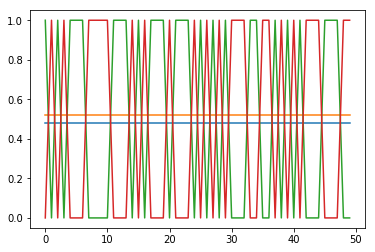

In [141]:
pred = model.predict(test_X)

plt.plot(pred)
plt.plot(test_y)
plt.show()